In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

from anyio.functools import initial_missing

print(f"Çalışma dizini {os.getcwd()}")

Çalışma dizini C:\Users\ACER\Documents\Github\Software_Testing_Project\HumanOrAI\data\pipeline


In [3]:
try:
    df_human = pd.read_csv('human_data_arxiv.csv')
    df_ai = pd.read_csv('ai_data_gemini.csv')
    print("Dosyalar okundu.")
except FileNotFoundError:
    print("Dosyalan bulunamadı!")

Dosyalar okundu.


###Veriler birleştiriliyor###

In [4]:
df_human['label'] = 0
df_ai['label'] = 1

df_human['generated_by'] = 'human_arxiv'
df_ai['generated_by'] = df_ai['source']

cols = ['title', 'text', 'subject', 'label', 'generated_by']
df_merged = pd.concat([df_human[cols], df_ai[cols]],ignore_index=True)

print(f"İnsan: {len(df_human)}, AI: {len(df_ai)}, Toplam: {len(df_merged)}")

df_merged.to_csv('1-merged_data.csv',index=False)
print("Kaydedildi: 1-merged_data.csv")

İnsan: 3005, AI: 3109, Toplam: 6114
Kaydedildi: 1-merged_data.csv


###Tekrar eden veriler tek olacak şekilde düzeltiliyor ve tekrarlar siliniyor###

In [5]:
df = pd.read_csv("1-merged_data.csv")
initial_len = len(df)

df.dropna(subset= ['text', 'title'], inplace = True)

df.drop_duplicates(subset= ['text'], keep="first", inplace=True)

df = df[df['text'].str.len() > 50]

print(f"Temizlik öncesi: {initial_len}, Sonrası: {len(df)}")
print(f"Silinen ver: {initial_len-len(df)}")

df.to_csv('2-duplicated_data.csv', index=False)
print("Kaydedildi: 2-duplicated_data.csv")


Temizlik öncesi: 6114, Sonrası: 6114
Silinen ver: 0
Kaydedildi: 2-duplicated_data.csv


###Metin İşleme ve metinlerin modellere uygun hale getirilmesi###

In [7]:
df = pd.read_csv('2-duplicated_data.csv')

def clean_text(text):
    if not isinstance(text,str):
        return ""
    text = text.lower()
    text = re.sub(r'\[.*?\]','',text)
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    text = re.sub(r'<.*?>','',text)
    text = re.sub(f'[{re.escape(string.punctuation)}]','',text)
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\s+', ' ',text).strip()
    return text

print("Metinler Temizleniyor...")
df['cleaned_text'] = df['text'].apply(clean_text)

df = df[df['cleaned_text'].str.len() > 10]
df.to_csv('3-cleaned_preprocessed_data.csv', index = False)
print("Kaydedildi: 3-cleaned-preprocessed_data.csv")
print(df[['text','cleaned_text']].head(1))

Metinler Temizleniyor...
Kaydedildi: 3-cleaned-preprocessed_data.csv
                                                text  \
0  In this paper, we introduce a novel framework ...   

                                        cleaned_text  
0  in this paper we introduce a novel framework u...  


###Grafikler ve görselleştirme###

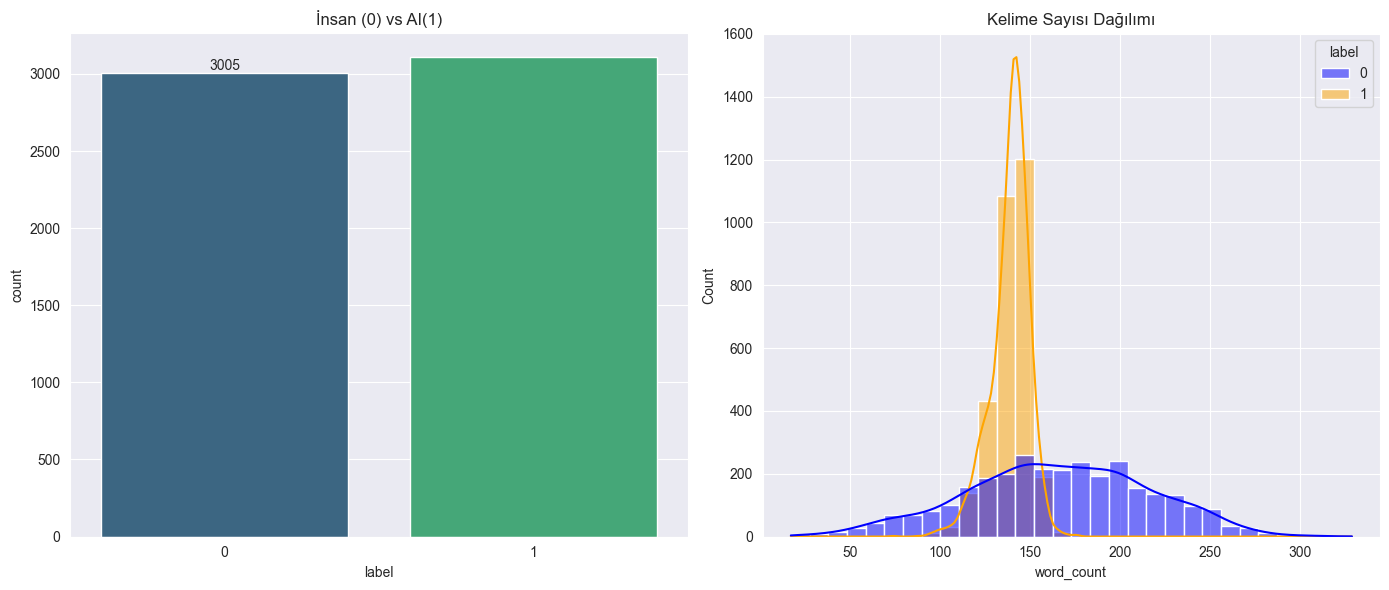

Grafik kaydedildi: EDA_Graphs.png


In [9]:
df = pd.read_csv('3-cleaned_preprocessed_data.csv')
df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
ax = sns.countplot(x='label', hue='label', data=df, palette='viridis', legend=False)
ax.bar_label(ax.containers[0])
plt.title("İnsan (0) vs AI(1)")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='label', kde=True, palette={0: 'blue', 1: 'orange'}, bins=30)
plt.title("Kelime Sayısı Dağılımı")

plt.tight_layout()
plt.savefig("EDA_Graphs.png")
plt.show()
print("Grafik kaydedildi: EDA_Graphs.png")
